In [42]:
import sys, os, sys, glob, importlib, random
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import tensorflow as tf
from scipy import ndimage, signal

from tensorflow.math import confusion_matrix
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPool2D, Flatten, Input


In [ ]:
path_to_prj = os.getcwd()

path = path_to_prj + '/data/tumor/'
file_names = [os.path.basename(f) for f in glob.glob(path+'*.jpg')]

wanted_size = 180


for i in range(len(file_names)):  
    im = Image.open(path+file_names[i]).convert('RGB') #open images and convert all to rgb
    f, e = os.path.splitext(path+file_names[i])
    resized = im.resize((wanted_size,wanted_size), Image.ANTIALIAS) #resize images and constant size
    resized.save(f + '_resized.jpg', 'JPEG', quality=90)

In [ ]:
path = path_to_prj + '/data/tumor/'
file_names = [os.path.basename(f) for f in glob.glob(path+'*.jpg')]

In [ ]:
len(file_names)

In [ ]:
for i in range(len(file_names)):  
    im = Image.open(path+file_names[i]).convert('RGB')
    f, e = os.path.splitext(path+file_names[i])
    resized = im.resize((180,180), Image.ANTIALIAS)
    resized.save(f + '_resized.jpg', 'JPEG', quality=90)

In [ ]:
file_names_resized = [os.path.basename(f) for f in glob.glob(path+'*_resized.jpg')]

In [ ]:
len(file_names_resized)

In [4]:
class ImageLoader():
    
    def __init__(
        self, 
        file_names=None,
        image_path=None, 
        mask_path=None, 
        roi_path=None, 
        image_extension='',
        mask_extension='',
        roi_extension='',
        window_size=96, 
        device=None,
        verbose=False):
        
        # initialize
        super().__init__()
        self.file_names = file_names
        self.image_path = image_path
        self.mask_path = mask_path
        self.roi_path = roi_path
        self.image_extension = image_extension
        self.mask_extension = mask_extension
        self.roi_extension = roi_extension
        self.window_size = window_size
        self.device = device
        
    def __len__(self):
        return len(self.file_names)
        
    # load RGB image
    def load_image(self, path, pad=None):
        w = int(self.window_size/2)
        image = np.array(Image.open(path))[::2, ::2]#, dtype=np.float32)/255
        if pad is not None:
            image = np.pad(
                array=image, 
                pad_width=[[w,w],[w,w],[0,0]], 
                mode='constant', 
                constant_values=pad)
        return image # [H, W, 3]
        
    # load binary mask
    def load_mask(self, path, pad=None):
        w = int(self.window_size/2)
        mask = np.array(Image.open(path))[::2, ::2]#, dtype=np.float32)/255
        if len(mask.shape) == 3:
            mask = mask[:,:,0]
        if pad is not None:
            mask = np.pad(
                array=mask, 
                pad_width=[[w,w],[w,w]], 
                mode='constant', 
                constant_values=pad)
        return mask # [H, W]
    
    # load images, masks, and ROIs
    def load_data(self, paths=None):
        images, masks, rois = [], [], []
        file_names = paths if paths is not None else self.file_names
        for file_name in tqdm(file_names):
            image_name = self.image_path + file_name.replace(self.mask_extension, self.image_extension)
            mask_name = self.mask_path + file_name
            images.append(self.load_image(image_name, pad=255.0)) # [N, H, W, 3]
            masks.append(self.load_mask(mask_name, pad=0.0)) # [N, H, W]
            if self.roi_path is not None:
                roi_name = self.roi_path + file_name.replace(self.mask_extension, self.roi_extension)
                rois.append(self.load_mask(roi_name, pad=0.0))  # [N, H, W]
        return images, masks, rois

100%|██████████| 35/35 [00:00<00:00, 497.02it/s]

Loading data...
Plotting examples...


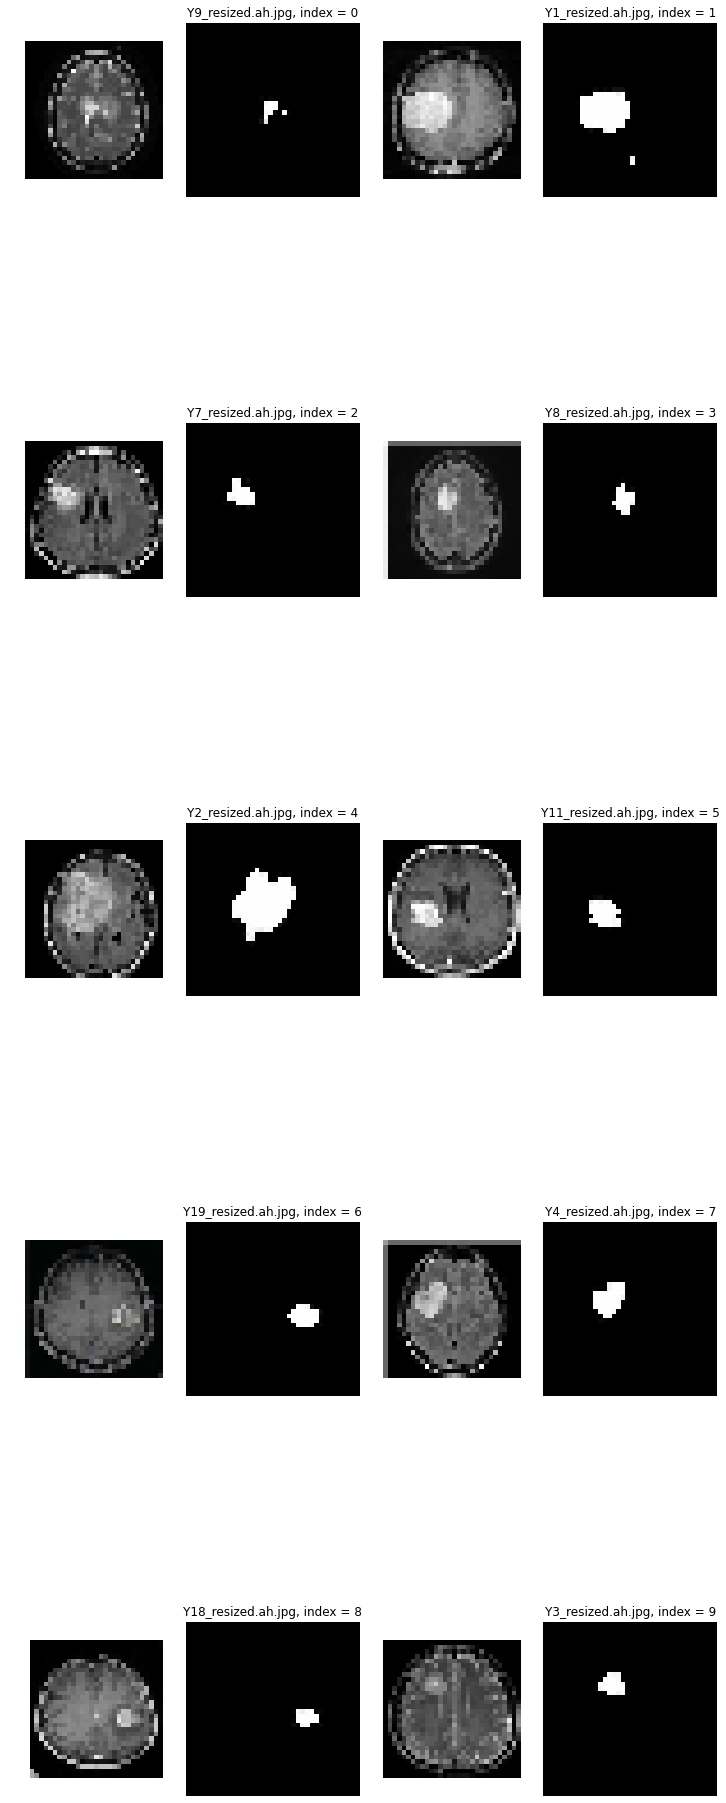

In [39]:
#
# load images, masks, and ROIs
#

# options

path_to_prj = os.getcwd()
image_path = path_to_prj + '/data/training/images/'
mask_path = path_to_prj + '/data/training/masks/'
window_size = 24
plot = True
imsize = 10
file_names = [os.path.basename(f) for f in glob.glob(mask_path+'*.ah.jpg')]

# initialize loader
IL = ImageLoader(
    file_names=file_names,
    image_path=image_path, 
    mask_path=mask_path,  
    roi_path=None,
    image_extension='.jpg',
    mask_extension='.ah.jpg',
    window_size=window_size, 
    verbose=True)

# load data
print('Loading data...')
file_names = IL.file_names.copy()
images, masks, _ = IL.load_data()

# plot
if plot:
    print('Plotting examples...')
    size = [images[0].shape[0], images[0].shape[1]]
    fig = plt.figure(figsize=(size[1]/size[0]*imsize, min(10, len(IL)/2)*imsize))
    for i in range(min(10, len(IL))):
        ax = fig.add_subplot(int(np.ceil(len(IL)/2)), 4, 2*i+1)
        plt.imshow(images[i][::3,::3]) #, aspect='auto'
        plt.axis('off')
        ax = fig.add_subplot(int(np.ceil(len(IL)/2)), 4, 2*i+2)
        plt.imshow(masks[i][::3,::3], cmap='gray') #aspect='auto',
        plt.axis('off')
        plt.title(file_names[i]+', index = {0}'.format(i))
    plt.tight_layout(pad=0.5)
    plt.show()

In [40]:
class ImageDataset():
    
    def __init__(
        self, 
        images, 
        masks, 
        rois=None, 
        window_size=96, 
        augment=False,
        bbox=False,
        dilate=0,
        verbose=False):
        
        # initialize
        super().__init__()
        self.images = images
        self.masks = masks
        self.rois = rois
        self.window_size = window_size
        self.augment = augment
        self.bbox = bbox
        self.dilate = dilate
        self.verbose = verbose
        
        # break masks into foreground/background indices
        self.indices = self.extract_locations(images, masks, rois, bbox=self.bbox)
        
        # define row/col locations for sampling rotated tiles
        w = int(self.window_size/2)
        X, Y = np.meshgrid(np.arange(-w, w), np.arange(-w, w), indexing='ij')
        self.image_slice = np.concatenate([X.reshape(-1, 1), Y.reshape(-1, 1)], axis=1)
        
    def __len__(self):
        return len(self.indices)
    
    # swap image axes [H, W, C] -> [C, H, W]
    def channels_first(self, image):
        return np.swapaxes(np.swapaxes(image, 0, 2), 1, 2)
    
    # swap image axes [C, H, W] -> [H, W, C]
    def channels_last(self, image):
        return np.swapaxes(np.swapaxes(image, 0, 2), 0, 1)
    
    # convert numpy image to torch tensor
    def image2torch(self, image):
        image = tf.convert_to_tensor(self.channels_first(image), dtype=tf.float32) # [3, H, W]
        return image
    
    # convert numpy mask to torch tensor
    def mask2torch(self, mask):
        mask = np.concatenate([mask[None], np.abs(-(mask[None]-1))], axis=0)
        mask = tf.convert_to_tensor(mask, dtype=tf.float32) # [2, H, W]
        return mask
    
    # convert torch tensor to numpy image
    def image2numpy(self, image):
        image = self.channels_last(tf.stop_gradient(image).cpu().numpy()) # [H, W, 3]
        return image
    
    # convert torch tensor to numpy mask
    def mask2numpy(self, mask):
        mask = tf.stop_gradient(mask[0]).cpu().numpy() # [H, W]
        return mask
    
    # build rotation matrix based on angle (in radians)
    def build_rotation_matrix(self, theta):
        return np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
    
    # sobel filter for edge detection
    def sobel(self, image):
        G_x = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=float)
        G_y = np.array([[-1, -2, -1], [ 0,  0,  0], [ 1,  2,  1]], dtype=float)
        edges = np.zeros(image.shape)
        for i in range(image.shape[-1]):
            x = signal.convolve(image[:,:,i], G_x, mode='same')
            y = signal.convolve(image[:,:,i], G_y, mode='same')
            edges[:,:,i] = (x**2 + y**2)**0.5
        edges = edges.mean(-1)
        return edges
    
    # get foreground and background pixel locations
    def extract_locations(self, images, masks, rois=None, bbox=False):
        
        # loop over each mask
        w = int(self.window_size/2)
        indices = []
        loop = tqdm(range(len(masks))) if self.verbose else range(len(masks))
        for i in loop:
            
            # get foreground/background masks
            f_mask = np.round(masks[i][w:-w,w:-w]/255).clip(0, 1)
            b_mask = 1 - np.round(masks[i][w:-w,w:-w]/255).clip(0, 1)
            
            # apply sobel filter
            edges = self.sobel(images[i][w:-w,w:-w].copy())
            edges[:w], edges[-w:], edges[:, :w], edges[:, -w:] = 0, 0, 0, 0
            
            # find points of interest
            values = np.sort(edges.reshape(-1))
            edges = edges > values[int(0.99*len(values))]
            if self.dilate > 0: 
                edges = ndimage.binary_dilation(edges, iterations=self.dilate)
            b_mask = b_mask * edges
            
            #plt.imshow(images[i])
            #plt.show()
            #plt.imshow(f_mask)
            #plt.show()
            #plt.imshow(b_mask)
            #plt.show()
            
            # convert mask to index
            f_idx = np.array(np.where(f_mask)).T + w # [F, 2]
            b_idx = np.array(np.where(b_mask)).T + w # [B, 2]
            
            # randomly subsample background locations
            m = min(10*len(f_idx), len(b_idx))
            b_idx = b_idx[np.random.permutation(len(b_idx))[:m]] # [N*F, 2]
            
            # combine and include image indices
            idx = np.concatenate([f_idx, b_idx], axis=0) # [(N+1)*F, 2]
            idx = np.concatenate([i*np.ones_like(idx[:,0:1]), idx], axis=1) # [(N+1)*F, 3]
            indices.append(idx)
        
        # shuffle
        indices = np.concatenate(indices, axis=0)
        indices = indices[np.random.permutation(len(indices))].astype(int)
        
        return indices
    
    def __getitem__(self, index):
        
        # get index
        idx = self.indices[index]
        i, j, k = idx[0], idx[1], idx[2]
        
        # optionally apply rotation
        theta = 0 #np.random.choice(np.linspace(0, 2*np.pi, 360)) if self.augment else 0
        rotation = self.build_rotation_matrix(theta)
        locs = (np.array([[j, k]]) + np.dot(rotation, self.image_slice.T).T).astype(int)
        
        # extract tiles by (rotated) pixel locations, convert to torch
        w = self.window_size
        tile = self.images[i][locs[:,0], locs[:,1]].reshape(w, w, 3)
        mask = self.masks[i][locs[:,0], locs[:,1]].reshape(w, w)
        tile = self.image2torch(tile.astype(np.float32)/255)
        mask = self.mask2torch(np.round(mask.astype(np.float32)/255))
        
#         if self.augment:
        
#              # random horizontal flips
#             if random.random() > 0.5:
#                 tile = torchvision.transforms.functional.hflip(tile)
#                 mask = torchvision.transforms.functional.hflip(mask)

#             # random color augmentation
#             tile = torchvision.transforms.ColorJitter(
#                 brightness=0.5,
#                 contrast=0.5,
#                 hue=0.1, 
#                 saturation=0.1)(tile)
            
#             # random blur
#             kernel = np.random.choice([2*i+1 for i in range(5)])
#             tile = torchvision.transforms.GaussianBlur(
#                 kernel_size=kernel, sigma=(0.1, 1))(tile)
            
#             # clip
#             tile = tile.clamp(0, 1)
            
        # zoom into center of mask
        w = int(self.window_size/2)
        mask = mask[:, w-1:w+2, w-1:w+2]
        
        return tile, mask

100%|██████████| 7/7 [00:00<00:00, 221.60it/s]

Loading training samples...
Loading validation samples...
train: 67,230, val: 18,025

Training examples:


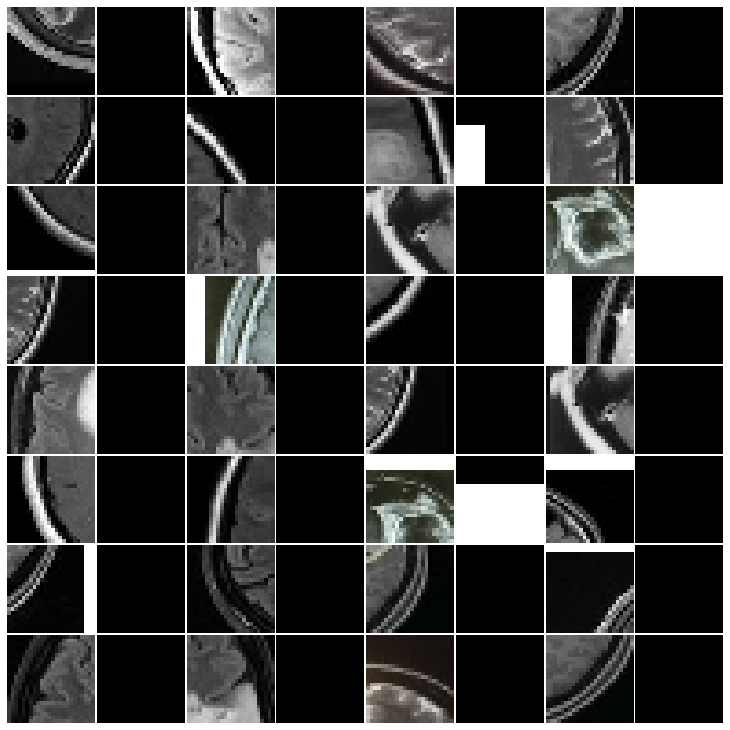

Validation examples:


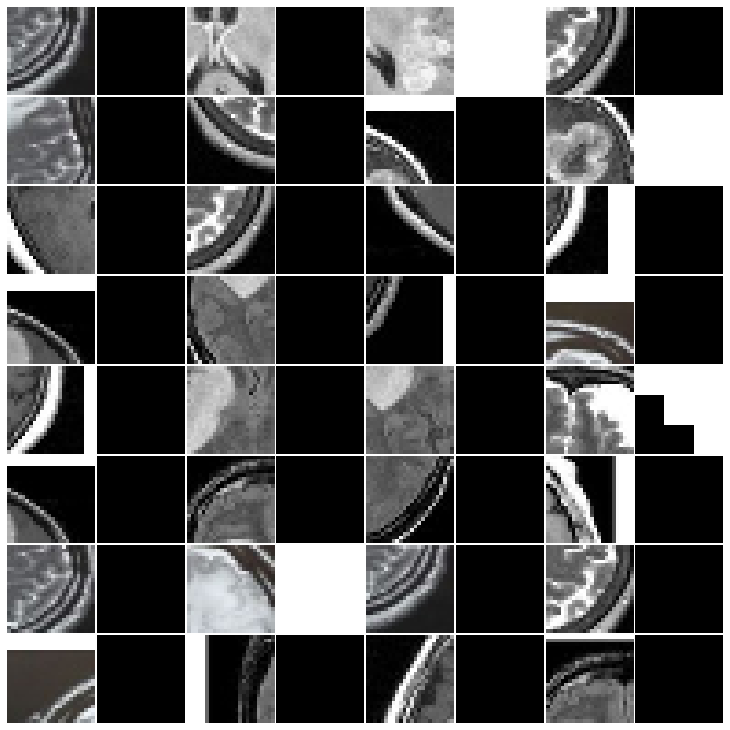

In [49]:
# options
plot = True
bbox = False
dilate = 10
verbose = True
val_img_idx = np.random.permutation(len(masks))[:int(0.2*len(masks))]

# compile data loaders
print('Loading training samples...')
train_dataset = ImageDataset(
    images=[images[i] for i in range(len(images)) if i not in val_img_idx], 
    masks=[masks[i] for i in range(len(masks)) if i not in val_img_idx], 
    window_size=window_size, 
    augment=True,
    bbox=bbox,
    dilate=dilate,
    verbose=verbose)
print('Loading validation samples...')
val_dataset = ImageDataset(
    images=[images[i] for i in range(len(images)) if i in val_img_idx], 
    masks=[masks[i] for i in range(len(masks)) if i in val_img_idx], 
    window_size=window_size, 
    augment=False,
    bbox=bbox,
    dilate=dilate,
    verbose=verbose)

print('train: {0:,}, val: {1:,}'.format(
    len(train_dataset), len(val_dataset)))
print()

# plot example input/output tiles
if plot:
    print('Training examples:')
    fig = plt.figure(figsize=(10, 10))
    N = len(train_dataset)
    for i in range(32):
        rand_idx = np.random.choice(N)
        input, output = train_dataset[rand_idx]
        ax = fig.add_subplot(8, 8, 2*i+1)
        plt.imshow(train_dataset.image2numpy(input), aspect='auto', vmin=0, vmax=1)
        plt.axis('off')
        ax = fig.add_subplot(8, 8, 2*i+2)
        plt.imshow(train_dataset.mask2numpy(output), aspect='auto', cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
    plt.tight_layout(pad=0.2)
    plt.show()

# plot example input/output tiles
if plot:
    print('Validation examples:')
    fig = plt.figure(figsize=(10, 10))
    N = len(val_dataset)
    for i in range(32):
        rand_idx = np.random.choice(N)
        input, output = val_dataset[rand_idx]
        ax = fig.add_subplot(8, 8, 2*i+1)
        plt.imshow(val_dataset.image2numpy(input), aspect='auto', vmin=0, vmax=1)
        plt.axis('off')
        ax = fig.add_subplot(8, 8, 2*i+2)
        plt.imshow(val_dataset.mask2numpy(output), aspect='auto', cmap='gray', vmin=0, vmax=1)
        plt.axis('off')
    plt.tight_layout(pad=0.2)
    plt.show()

In [55]:
input, output = val_dataset[1]

In [56]:
input

<tf.Tensor: shape=(3, 24, 24), dtype=float32, numpy=
array([[[0.69411767, 0.81960785, 0.7372549 , ..., 0.38039216,
         0.3254902 , 0.35686275],
        [0.42352942, 0.654902  , 0.76862746, ..., 0.7764706 ,
         0.5686275 , 0.3647059 ],
        [0.24705882, 0.3529412 , 0.52156866, ..., 0.37254903,
         0.38039216, 0.40392157],
        ...,
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ],
        [1.        , 1.        , 1.        , ..., 1.        ,
         1.        , 1.        ]],

       [[0.7254902 , 0.8392157 , 0.75686276, ..., 0.4       ,
         0.34509805, 0.3764706 ],
        [0.44313726, 0.6745098 , 0.7882353 , ..., 0.79607844,
         0.5882353 , 0.38431373],
        [0.26666668, 0.37254903, 0.5411765 , ..., 0.39215687,
         0.4       , 0.42352942],
        ...,
        [1.        , 1.        , 1.        , ..., 1.   

In [45]:
print("Initializing network...")
model = Sequential()
model.add(
    Conv2D(40, kernel_size=(5, 5), strides=(1, 1), padding='valid', activation='relu', input_shape=(180, 180, 1)))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(180, activation='softmax'))
#model.summary()
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2)
model.compile(loss='categorical_crossentropy', metrics=['loss'], optimizer=opt)
# training the model for 10 epochs
model_out = model.fit(train_dataset, batch_size=128, epochs=100, validation_data=(val_dataset), callbacks=[early_stopping])


Initializing network...


ValueError: Failed to find data adapter that can handle input: <class '__main__.ImageDataset'>, <class 'NoneType'>